# Credit Card Application

Our goal is to build a ML model to predict if an applicant is a 'good' or 'bad' client. We will be using classification models to train and test the data found on kaggel found here: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction

The data given is in two different csv files. We will need to clean and merge the data from both files. Addidionally we will create a target variable we will call "At_Risk". This is the variable we will run our classification models on. 

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Data Cleaning and EDA

The code for the data cleaning is borrowed from Kaggel contributor SAMUEL CORTINHAS. You can find his code for cleaning the data here: https://www.kaggle.com/code/samuelcortinhas/credit-cards-data-cleaning

## Data

We have two different data frames, one called applications and one called record. 

In [10]:
# Save to df
applications = pd.read_csv("application_record.csv", encoding = 'utf-8')
record = pd.read_csv("credit_record.csv", encoding = 'utf-8')

# Shape and preview
print('Application record df shape:', applications.shape)
applications.head()

Application record df shape: (438557, 18)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


Application has 18 features and 438557 entries. 

In [11]:
# Shape and preview
print('Credit record df shape:', record.shape)
record.head()

Credit record df shape: (1048575, 3)


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


Record has 3 features and 1048575 entries. 

**Missing values**

In [12]:
applications.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

<AxesSubplot:>

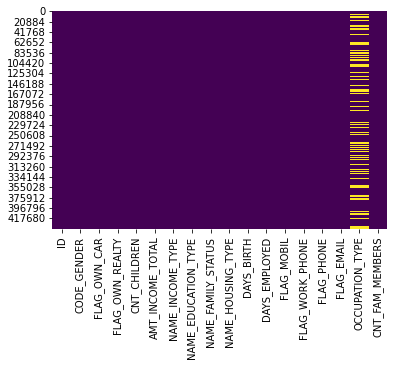

In [13]:
sns.heatmap(applications.isnull(),cbar=False,cmap='viridis')

The feature Occupation Type has some NA values. 

In [14]:
record.isna().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

<AxesSubplot:>

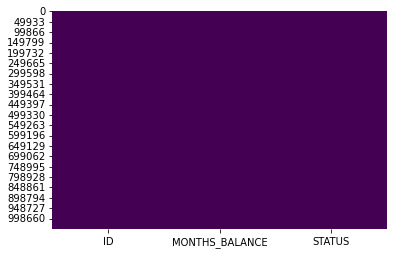

In [15]:
sns.heatmap(record.isnull(),cbar=False,cmap='viridis')

There are no NA values in the record data frame

**Duplicates**

In [16]:
print(f'Duplicates in applications df: {applications.iloc[:,1:].duplicated().sum()}, ({np.round(100*applications.iloc[:,1:].duplicated().sum()/len(applications),1)}%)')
print('')
print(f'Duplicates in record df: {record.duplicated().sum()}, ({np.round(100*record.duplicated().sum()/len(record),1)}%)')

Duplicates in applications df: 348472, (79.5%)

Duplicates in record df: 0, (0.0%)


The application data frame has a lot of duplicates! 

**Cardinality of features**

There is 1 constant feature, 6 binary features, 3 continuous features and 7 non-binary categorical features.

In [17]:
applications.nunique()

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

# Data Cleaning

**Drop duplicates**

In [18]:
# Drop duplicates
applications=applications.drop_duplicates(subset=applications.columns[1:], keep='first')

**Fill missing values**

In [19]:
# Fill missing values
applications['OCCUPATION_TYPE'].fillna(value='Other', inplace=True)

**Drop constant feature**

This won't be useful to our models because there is only one unique feature.

In [20]:
# Drop constant feature
applications.drop('FLAG_MOBIL', axis=1, inplace=True)

**Create target variable**

Because the credit records are incomplete (the ID ranges in both dfs don't match) we have to create our own target. We do this by identifying 'low risk' and 'high risk' credit users. We say a user is 'high risk' if during any month they are late on payments by 30 days or more, and 'low risk' otherwise. This is the target we will try to predict later.

In [21]:
# Construct target
record['At_Risk']=record['STATUS']
record['At_Risk'].replace('X', 0, inplace=True)
record['At_Risk'].replace('C', 0, inplace=True)
record['At_Risk']=record['At_Risk'].astype(int)
record.loc[record['At_Risk']>=1,'At_Risk']=1

# target=1 (high risk) iff there is at least one month where user is late on payments by 30 days or more
target_df=pd.DataFrame(record.groupby(['ID'])['At_Risk'].agg(max)).reset_index()

# Merge dataframes
new_df=pd.merge(applications, target_df, how='inner', on=['ID'])

**Account length**

It makes sense that the number of months the account has been open for correlates with the riskiness of the customer (since there are more opportunity to miss payments).

In [22]:
# Extract how many months account has been open for
start_df=pd.DataFrame(record.groupby(['ID'])['MONTHS_BALANCE'].agg(min)).reset_index()

# Rename column
start_df.rename(columns={'MONTHS_BALANCE':'ACCOUNT_LENGTH'}, inplace=True)

# Make entries positive
start_df['ACCOUNT_LENGTH']=-start_df['ACCOUNT_LENGTH']

# Merge dataframes on ID
new_df=pd.merge(new_df, start_df, how='inner', on=['ID'])

**Continuous features**

In [23]:
# Create age feature
new_df['AGE_YEARS']=-new_df['DAYS_BIRTH']/365.2425
new_df.drop('DAYS_BIRTH', axis=1, inplace=True)

# Create unemployed indicator
new_df['UNEMPLOYED']=0
new_df.loc[-new_df['DAYS_EMPLOYED']<0,'UNEMPLOYED']=1

# Create years employed feature
new_df['YEARS_EMPLOYED']=-new_df['DAYS_EMPLOYED']/365.2425
new_df.loc[new_df['YEARS_EMPLOYED']<0,'YEARS_EMPLOYED']=0
new_df.drop('DAYS_EMPLOYED', axis=1, inplace=True)

**Encoding categorical features**

In [24]:
# Encode binary features
new_df["CODE_GENDER"] =  new_df["CODE_GENDER"].replace(['F','M'],[1,0])
new_df["FLAG_OWN_CAR"] = new_df["FLAG_OWN_CAR"].replace(["Y","N"],[1,0])
new_df["FLAG_OWN_REALTY"] = new_df["FLAG_OWN_REALTY"].replace(["Y","N"],[1,0])

**Rename columns**

In [25]:
new_df = new_df.rename(columns={'CODE_GENDER': 'Gender', 'FLAG_OWN_CAR': 'Own_car', 
                               'FLAG_OWN_REALTY':'Own_property','CNT_CHILDREN':'Num_children',
                               'AMT_INCOME_TOTAL':'Total_income','NAME_INCOME_TYPE':'Income_type',
                               'NAME_EDUCATION_TYPE':'Education_type','NAME_FAMILY_STATUS':'Family_status',
                               'NAME_HOUSING_TYPE':'Housing_type','FLAG_WORK_PHONE':'Work_phone',
                               'FLAG_PHONE':'Phone','FLAG_EMAIL':'Email','OCCUPATION_TYPE':'Occupation_type',
                               'CNT_FAM_MEMBERS':'Num_family','target':'Target','ACCOUNT_LENGTH':'Account_length',
                                'AGE_YEARS':'Age','UNEMPLOYED':'Unemployed','YEARS_EMPLOYED':'Years_employed'})

**Data type**

In [26]:
new_df['Num_family']=new_df['Num_family'].astype(int)

**Re-order columns**

In [27]:
new_df.columns

Index(['ID', 'Gender', 'Own_car', 'Own_property', 'Num_children',
       'Total_income', 'Income_type', 'Education_type', 'Family_status',
       'Housing_type', 'Work_phone', 'Phone', 'Email', 'Occupation_type',
       'Num_family', 'At_Risk', 'Account_length', 'Age', 'Unemployed',
       'Years_employed'],
      dtype='object')

In [28]:
new_df=new_df[['ID', 'Gender', 'Own_car', 'Own_property', 'Work_phone',
               'Phone', 'Email', 'Unemployed', 'Num_children', 'Num_family', 
               'Account_length', 'Total_income', 'Age', 'Years_employed',  
               'Income_type', 'Education_type', 'Family_status',
               'Housing_type', 'Occupation_type','At_Risk']]

In [29]:
new_df.drop('ID', axis=1, inplace=True)

# Output

In [30]:
# Shape and preview
print('New df shape:', new_df.shape)
new_df.head()

New df shape: (9709, 19)


,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,At_Risk
0,0,1,1,1,0,0,0,0,2,15,427500.0,32.868574,12.435574,Working,Higher education,Civil marriage,Rented apartment,Other,1
1,0,1,1,0,0,0,0,0,2,29,112500.0,58.793815,3.104787,Working,Secondary / secondary special,Married,House / apartment,Security staff,0
2,1,0,1,0,1,1,0,0,1,4,270000.0,52.321403,8.353354,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,0
3,1,0,1,0,0,0,1,0,1,20,283500.0,61.504343,0.000000,Pensioner,Higher education,Separated,House / apartment,Other,0
4,0,1,1,1,1,1,0,0,2,5,270000.0,46.193967,2.105450,Working,Higher education,Married,House / apartment,Accountants,0


In [31]:
# Data types
new_df.dtypes

Gender               int64
Own_car              int64
Own_property         int64
Work_phone           int64
Phone                int64
Email                int64
Unemployed           int64
Num_children         int64
Num_family           int64
Account_length       int64
Total_income       float64
Age                float64
Years_employed     float64
Income_type         object
Education_type      object
Family_status       object
Housing_type        object
Occupation_type     object
At_Risk              int64
dtype: object

In [32]:
# Save to csv
new_df.to_csv('clean_data.csv',index=False)

# Exploratory Data Analysis – EDA

Now that we have cleaned the data and created a target variable, let's learn a little more about the data we are working with through an EDA. 

In [33]:
df = pd.read_csv('clean_data.csv')

In [34]:
df.head()

,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,At_Risk
0,0,1,1,1,0,0,0,0,2,15,427500.0,32.868574,12.435574,Working,Higher education,Civil marriage,Rented apartment,Other,1
1,0,1,1,0,0,0,0,0,2,29,112500.0,58.793815,3.104787,Working,Secondary / secondary special,Married,House / apartment,Security staff,0
2,1,0,1,0,1,1,0,0,1,4,270000.0,52.321403,8.353354,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,0
3,1,0,1,0,0,0,1,0,1,20,283500.0,61.504343,0.000000,Pensioner,Higher education,Separated,House / apartment,Other,0
4,0,1,1,1,1,1,0,0,2,5,270000.0,46.193967,2.105450,Working,Higher education,Married,House / apartment,Accountants,0


In [35]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,9709.0,0.651251,0.476599,0.000000,0.000000,1.000000,1.000000,1.000000e+00
Own_car,9709.0,0.367700,0.482204,0.000000,0.000000,0.000000,1.000000,1.000000e+00
Own_property,9709.0,0.671542,0.469677,0.000000,0.000000,1.000000,1.000000,1.000000e+00
Work_phone,9709.0,0.217427,0.412517,0.000000,0.000000,0.000000,0.000000,1.000000e+00
Phone,9709.0,0.287671,0.452700,0.000000,0.000000,0.000000,1.000000,1.000000e+00
Email,9709.0,0.087548,0.282650,0.000000,0.000000,0.000000,0.000000,1.000000e+00
Unemployed,9709.0,0.174683,0.379716,0.000000,0.000000,0.000000,0.000000,1.000000e+00
Num_children,9709.0,0.422804,0.767019,0.000000,0.000000,0.000000,1.000000,1.900000e+01
Num_family,9709.0,2.182614,0.932918,1.000000,2.000000,2.000000,3.000000,2.000000e+01
Account_length,9709.0,27.270059,16.648057,0.000000,13.000000,26.000000,41.000000,6.000000e+01


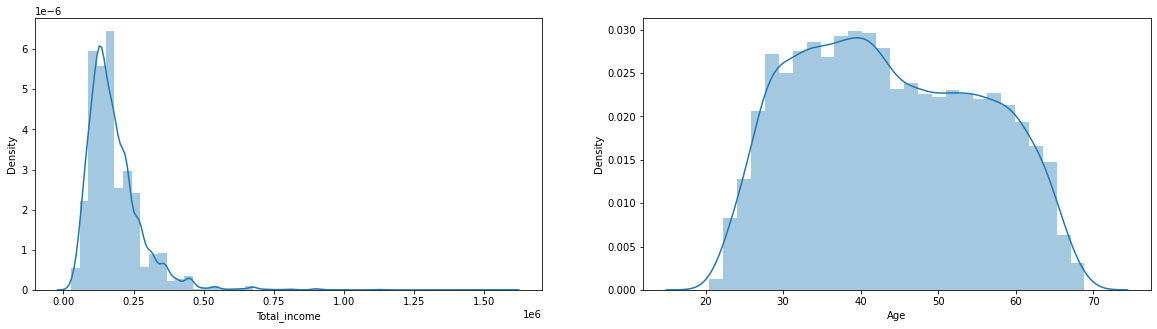

In [36]:
plt.subplots(figsize=(20,5))
plt.subplot(121)
sns.distplot(df.Total_income)

plt.subplot(122)
sns.distplot(df.Age)

plt.show()

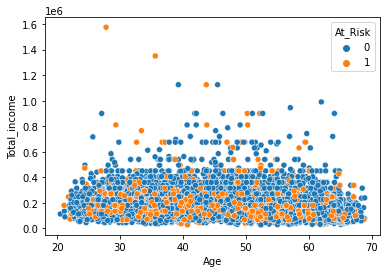

In [37]:
sns.scatterplot(x='Age', y='Total_income', hue = 'At_Risk', data=df)
plt.show()

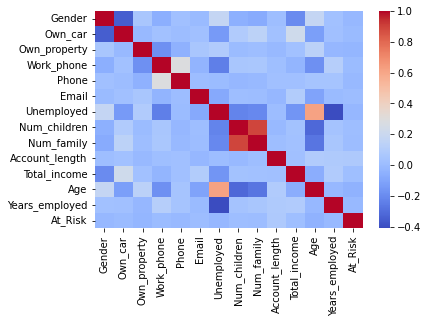

In [38]:
sns.heatmap(df.corr(), cmap='coolwarm',annot=False)
plt.show()

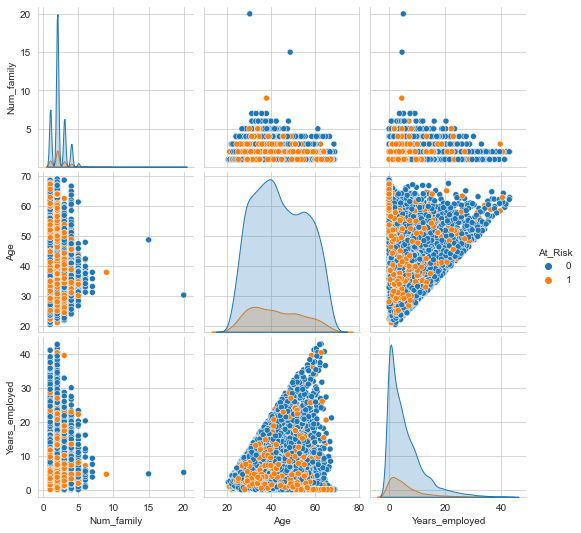

In [43]:
sns.set_style('whitegrid')
sns.pairplot(df, hue='At_Risk', vars = ['Num_family', 'Age', 'Years_employed'])
plt.show()

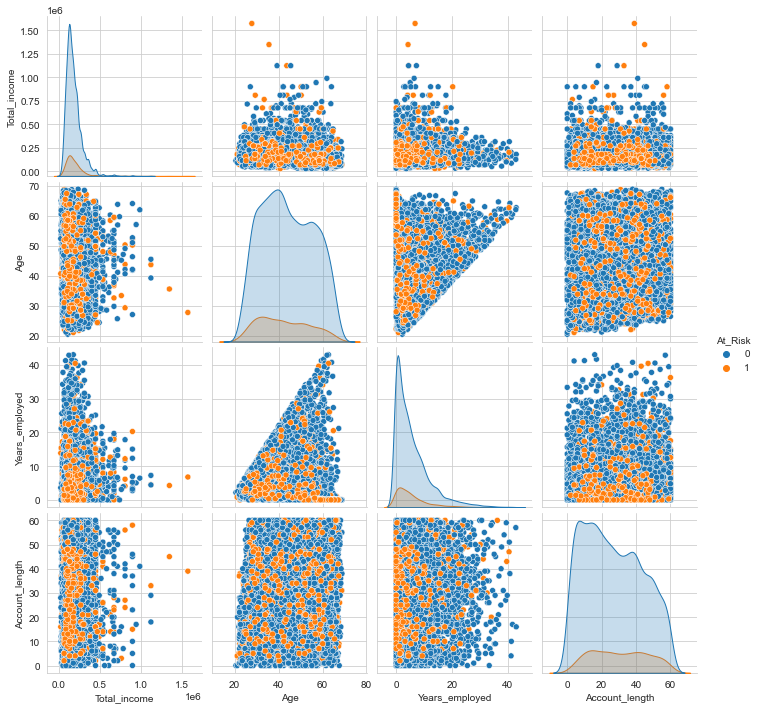

In [40]:
sns.set_style('whitegrid')
sns.pairplot(df, hue='At_Risk', vars = ['Total_income', 'Age', 'Years_employed', 'Account_length'])
plt.show()

<AxesSubplot:xlabel='At_Risk', ylabel='count'>

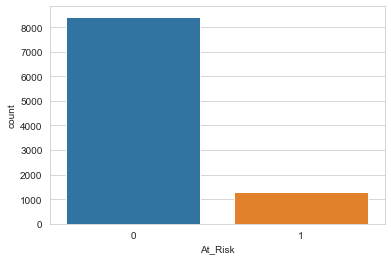

In [21]:
sns.countplot(x = 'At_Risk', data = df)

<AxesSubplot:xlabel='Unemployed', ylabel='count'>

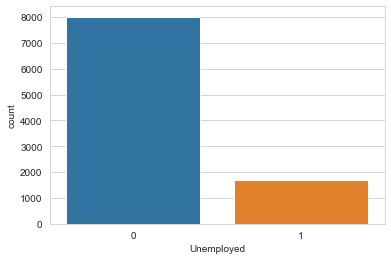

In [22]:
sns.countplot(x = 'Unemployed', data = df)

Male: Gender = 0, Female: Gender = 1

<AxesSubplot:xlabel='Gender', ylabel='count'>

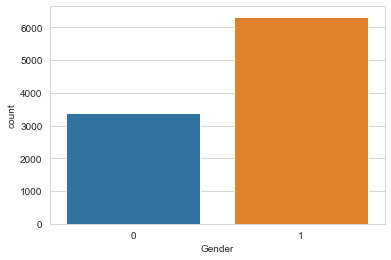

In [23]:
sns.countplot(x = 'Gender', data = df)

# Machine Learning Models

## 1. Logistic Regression

In [2]:
rand_state = 1000

In [3]:
df = pd.read_csv('clean_data.csv')

In [4]:
df.head()

,ID,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,At_Risk
0,5008804,1,1,1,1,0,0,0,0,2,15,427500.0,32.868574,12.435574,Working,Higher education,Civil marriage,Rented apartment,Other,1
1,5008806,1,1,1,0,0,0,0,0,2,29,112500.0,58.793815,3.104787,Working,Secondary / secondary special,Married,House / apartment,Security staff,0
2,5008808,0,0,1,0,1,1,0,0,1,4,270000.0,52.321403,8.353354,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,0
3,5008812,0,0,1,0,0,0,1,0,1,20,283500.0,61.504343,0.000000,Pensioner,Higher education,Separated,House / apartment,Other,0
4,5008815,1,1,1,1,1,1,0,0,2,5,270000.0,46.193967,2.105450,Working,Higher education,Married,House / apartment,Accountants,0


In [5]:
df = df.drop("ID", axis=1, inplace = False)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           9709 non-null   int64  
 1   Own_car          9709 non-null   int64  
 2   Own_property     9709 non-null   int64  
 3   Work_phone       9709 non-null   int64  
 4   Phone            9709 non-null   int64  
 5   Email            9709 non-null   int64  
 6   Unemployed       9709 non-null   int64  
 7   Num_children     9709 non-null   int64  
 8   Num_family       9709 non-null   int64  
 9   Account_length   9709 non-null   int64  
 10  Total_income     9709 non-null   float64
 11  Age              9709 non-null   float64
 12  Years_employed   9709 non-null   float64
 13  Income_type      9709 non-null   object 
 14  Education_type   9709 non-null   object 
 15  Family_status    9709 non-null   object 
 16  Housing_type     9709 non-null   object 
 17  Occupation_typ

In [9]:
categorical = ['Gender', 'Own_car', 'Own_property', 'Work_phone', 'Phone', 'Email', 'Unemployed', 'Income_type','Education_type', 'Family_status', 'Housing_type', 'Occupation_type', 'At_Risk']

In [10]:
for col in categorical:
    df[col] = df[col].astype("category")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Gender           9709 non-null   category
 1   Own_car          9709 non-null   category
 2   Own_property     9709 non-null   category
 3   Work_phone       9709 non-null   category
 4   Phone            9709 non-null   category
 5   Email            9709 non-null   category
 6   Unemployed       9709 non-null   category
 7   Num_children     9709 non-null   int64   
 8   Num_family       9709 non-null   int64   
 9   Account_length   9709 non-null   int64   
 10  Total_income     9709 non-null   float64 
 11  Age              9709 non-null   float64 
 12  Years_employed   9709 non-null   float64 
 13  Income_type      9709 non-null   category
 14  Education_type   9709 non-null   category
 15  Family_status    9709 non-null   category
 16  Housing_type     9709 non-null   category


In [12]:
y = df['At_Risk']
pd.crosstab(y,y,normalize='all')*100

At_Risk,0,1
At_Risk,,
0,86.785457,0.000000
1,0.000000,13.214543


Dataset is not very balanced, we need to be careful when interpreting results

In [13]:
df.isna().sum()

Gender             0
Own_car            0
Own_property       0
Work_phone         0
Phone              0
Email              0
Unemployed         0
Num_children       0
Num_family         0
Account_length     0
Total_income       0
Age                0
Years_employed     0
Income_type        0
Education_type     0
Family_status      0
Housing_type       0
Occupation_type    0
At_Risk            0
dtype: int64

In [14]:
df_lr = pd.get_dummies(df,drop_first = True)

In [17]:
df_lr.head()

,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Gender_1,Own_car_1,Own_property_1,Work_phone_1,...,Occupation_type_Managers,Occupation_type_Medicine staff,Occupation_type_Other,Occupation_type_Private service staff,Occupation_type_Realty agents,Occupation_type_Sales staff,Occupation_type_Secretaries,Occupation_type_Security staff,Occupation_type_Waiters/barmen staff,At_Risk_1
0,0,2,15,427500.0,32.868574,12.435574,1,1,1,1,...,0,0,1,0,0,0,0,0,0,1
1,0,2,29,112500.0,58.793815,3.104787,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,4,270000.0,52.321403,8.353354,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,20,283500.0,61.504343,0.000000,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,2,5,270000.0,46.193967,2.105450,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
df_lr.describe()

,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Gender_1,Own_car_1,Own_property_1,Work_phone_1,...,Occupation_type_Managers,Occupation_type_Medicine staff,Occupation_type_Other,Occupation_type_Private service staff,Occupation_type_Realty agents,Occupation_type_Sales staff,Occupation_type_Secretaries,Occupation_type_Security staff,Occupation_type_Waiters/barmen staff,At_Risk_1
count,9709.000000,9709.000000,9709.000000,9.709000e+03,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,...,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000
mean,0.422804,2.182614,27.270059,1.812282e+05,43.784093,5.664730,0.348749,0.367700,0.671542,0.217427,...,0.080544,0.029972,0.308374,0.008858,0.001648,0.098774,0.004738,0.018745,0.004120,0.132145
std,0.767019,0.932918,16.648057,9.927731e+04,11.625768,6.342241,0.476599,0.482204,0.469677,0.412517,...,0.272147,0.170519,0.461846,0.093703,0.040564,0.298374,0.068672,0.135632,0.064057,0.338666
min,0.000000,1.000000,0.000000,2.700000e+04,20.504186,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,13.000000,1.125000e+05,34.059563,0.928150,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,26.000000,1.575000e+05,42.741466,3.761884,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,3.000000,41.000000,2.250000e+05,53.567151,8.200031,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,19.000000,20.000000,60.000000,1.575000e+06,68.863837,43.020733,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
y = df_lr['At_Risk_1']
X = df_lr.drop('At_Risk_1', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=rand_state)

In [19]:
X_train.head()

,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Gender_1,Own_car_1,Own_property_1,Work_phone_1,...,Occupation_type_Low-skill Laborers,Occupation_type_Managers,Occupation_type_Medicine staff,Occupation_type_Other,Occupation_type_Private service staff,Occupation_type_Realty agents,Occupation_type_Sales staff,Occupation_type_Secretaries,Occupation_type_Security staff,Occupation_type_Waiters/barmen staff
3037,1,3,6,202500.0,31.340822,8.295858,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9034,0,2,39,157500.0,46.292532,8.033019,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5397,0,2,29,225000.0,63.007454,0.000000,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
6430,0,2,58,135000.0,29.292867,1.095163,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7666,0,2,31,180000.0,55.308459,1.631793,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
y_train.head()

3037    0
9034    0
5397    0
6430    0
7666    0
Name: At_Risk_1, dtype: uint8

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
logistic = LogisticRegression(penalty='none')
logistic.fit(X_train, y_train)

LogisticRegression(penalty='none')

In [25]:
y_hat      = logistic.predict(X_test)
y_hat_probs = logistic.predict_proba(X_test)[:,1] 

In [26]:
np.round(logistic.predict_proba(X_test),3)

array([[0.902, 0.098],
       [0.922, 0.078],
       [0.86 , 0.14 ],
       ...,
       [0.919, 0.081],
       [0.883, 0.117],
       [0.891, 0.109]])

In [27]:
np.max(y_hat_probs)

0.29644037262382866

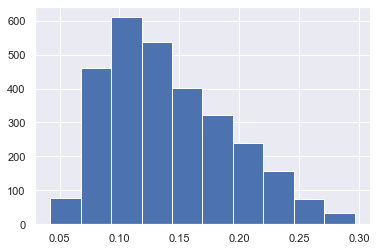

In [28]:
plt.hist(y_hat_probs)
plt.show()

I'm going to try thresholds of 15% and 20%

In [31]:
y_hat_15 = np.where(y_hat_probs>0.15,1,0)
y_hat_20 = np.where(y_hat_probs>0.20,1,0)

In [32]:
df_predictions = pd.DataFrame({'y_test':y_test, 'y_hat_probs':y_hat_probs,
                               'y_hat_15':y_hat_15, 'y_hat_30':y_hat_30})
df_predictions.tail()

,y_test,y_hat_probs,y_hat_15,y_hat_30
2756,0,0.128300,0,0
7381,1,0.206708,1,0
6388,0,0.081457,0,0
6252,0,0.116689,0,0
3854,0,0.108993,0,0


In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef



def my_logistic_report(X_train, y_train, X_test,y_test, threshold=0.5, penalty='none', class_weight=None): # you could make it even more general!
    logistic= LogisticRegression(class_weight=class_weight, penalty=penalty)
    logistic.fit(X_train, y_train)
    probs = logistic.predict_proba(X_test)[:,1]
    y_hat = np.where(probs>=threshold,1,0)
    
    cm = confusion_matrix(y_test, y_hat)
    accuracy = round(accuracy_score(y_test,y_hat) ,2)
    precision = round(precision_score(y_test,y_hat),2)
    recall = round(recall_score(y_test,y_hat),2)
    f1score = round(f1_score(y_test,y_hat),2)
    MCC = round(matthews_corrcoef(y_test,y_hat),2)
    cm_labled = pd.DataFrame(cm, index=['Actual : negative ','Actual : positive'], columns=['Predict : negative','Predict :positive '])
    
    print("-----------------------------------------")
    print('Accuracy  = {}'.format(accuracy))
    print('Precision = {}'.format(precision))
    print('Recall    = {}'.format(recall))
    print('f1_score  = {}'.format(f1score))
    print('MCC       = {}'.format(MCC))
    print("-----------------------------------------")
    return cm_labled

In [35]:
my_logistic_report(X_train, y_train, X_test,y_test, threshold=0.5)

-----------------------------------------
Accuracy  = 0.86
Precision = 0.0
Recall    = 0.0
f1_score  = 0.0
MCC       = 0.0
-----------------------------------------


,Predict : negative,Predict :positive
Actual : negative,2512,0
Actual : positive,401,0


In [36]:
my_logistic_report(X_train, y_train, X_test,y_test, threshold=0.2)

-----------------------------------------
Accuracy  = 0.75
Precision = 0.14
Recall    = 0.15
f1_score  = 0.15
MCC       = 0.0
-----------------------------------------


,Predict : negative,Predict :positive
Actual : negative,2131,381
Actual : positive,339,62


In [37]:
my_logistic_report(X_train, y_train, X_test,y_test, threshold=0.15)

-----------------------------------------
Accuracy  = 0.59
Precision = 0.14
Recall    = 0.39
f1_score  = 0.21
MCC       = 0.01
-----------------------------------------


,Predict : negative,Predict :positive
Actual : negative,1555,957
Actual : positive,245,156


In [38]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.505


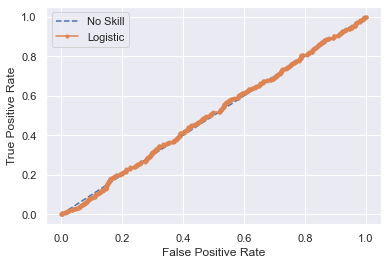

In [39]:
# generate a no skill (ns) prediction and logistic regression (lr) predictions.
ns_probs = [0 for i in range(len(y_test))]
lr_probs = logistic.predict_proba(X_test)[:,1]
# calculating scores for no skill and logistic regression
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## KNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier

In [46]:
KNN_classifier = KNeighborsClassifier()
KNN_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [47]:
y_hat      = KNN_classifier.predict(X_test)
y_hat_probs = KNN_classifier.predict_proba(X_test)[:,1] 

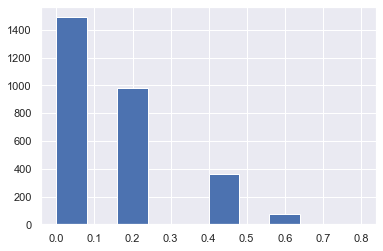

In [48]:
plt.hist(y_hat_probs)
plt.show()

In [49]:
y_hat_20 = np.where(y_hat_probs>0.2,1,0)
y_hat_50 = np.where(y_hat_probs>0.5,1,0)

In [51]:
df_predictions = pd.DataFrame({'y_test':y_test, 'y_hat':y_hat, 'y_hat_probs':y_hat_probs,
                               'y_hat_20':y_hat_20, 'y_hat_50':y_hat_50})
df_predictions.tail()

,y_test,y_hat,y_hat_probs,y_hat_20,y_hat_50
2756,0,0,0.0,0,0
7381,1,0,0.0,0,0
6388,0,0,0.4,1,0
6252,0,0,0.2,0,0
3854,0,0,0.2,0,0


In [52]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score



def my_KNN_report(X_train, y_train, X_test,y_test, K=5, threshold=0.5, weights='uniform'):
    knn= KNeighborsClassifier(n_neighbors=K, weights=weights)
    knn.fit(X_train, y_train)
    probs = knn.predict_proba(X_test)[:,1]
    y_hat = np.where(probs>=threshold,1,0)
    
    cm = confusion_matrix(y_test, y_hat)
    accuracy = round(accuracy_score(y_test,y_hat) ,4)
    error_rate = round(1-accuracy,4)
    precision = round(precision_score(y_test,y_hat),2)
    recall = round(recall_score(y_test,y_hat),2)
    f1score = round(f1_score(y_test,y_hat),2)
    cm_labled = pd.DataFrame(cm, index=['Actual : negative ','Actual : positive'], columns=['Predict : negative','Predict :positive '])
    
    print("-----------------------------------------")
    print('Accuracy  = {}'.format(accuracy))
    print('Error_rate  = {}'.format(error_rate))
    print('Precision = {}'.format(precision))
    print('Recall    = {}'.format(recall))
    print('f1_score  = {}'.format(f1score))
    print("-----------------------------------------")
    return cm_labled

In [55]:
my_KNN_report(X_train, y_train, X_test,y_test, K=5, threshold=0.2, weights='uniform')

-----------------------------------------
Accuracy  = 0.5201
Error_rate  = 0.4799
Precision = 0.15
Recall    = 0.53
f1_score  = 0.23
-----------------------------------------


,Predict : negative,Predict :positive
Actual : negative,1302,1210
Actual : positive,188,213


In [56]:
my_KNN_report(X_train, y_train, X_test,y_test, K=5, threshold=0.15, weights='uniform')

-----------------------------------------
Accuracy  = 0.5201
Error_rate  = 0.4799
Precision = 0.15
Recall    = 0.53
f1_score  = 0.23
-----------------------------------------


,Predict : negative,Predict :positive
Actual : negative,1302,1210
Actual : positive,188,213


No Skill: ROC AUC=0.500
KNN: ROC AUC=0.533


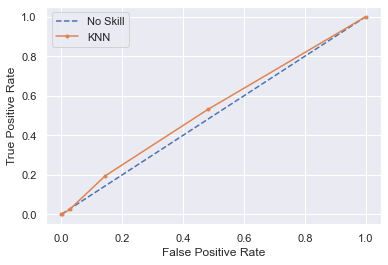

In [57]:
# generate a no skill (ns) prediction and KNN  (lr) predictions.
ns_probs = [0 for i in range(len(y_test))]
lr_probs = KNN_classifier.predict_proba(X_test)[:,1]
# calculating scores for no skill and KNN 
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('KNN: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='KNN')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## SVM

In [58]:
from sklearn.svm import SVC

In [59]:
# Fitting SVM regression to the Training set
SVM_classification = SVC()
SVM_classification.fit(X_train, y_train)

SVC()

In [60]:
# Predicting the Test set results
y_hat = SVM_classification.predict(X_test)

In [61]:
predictions = pd.DataFrame({ 'y_test':y_test,'y_hat':y_hat})
predictions.tail(20)

,y_test,y_hat
3080,0,0
7649,0,0
8683,0,0
1756,0,0
7628,0,0
6299,1,0
6714,0,0
4819,0,0
3232,0,0
2967,0,0


In [62]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef



def my_SVM_report(X_train, y_train, X_test,y_test, C=1,gamma='scale' ,kernel='rbf', class_weight=None):
    svc= SVC(C=C, gamma=gamma, kernel=kernel, class_weight=class_weight)
    svc.fit(X_train, y_train)
    y_hat = svc.predict(X_test)
    
    cm = confusion_matrix(y_test, y_hat)
    accuracy = round(accuracy_score(y_test,y_hat) ,4)
    error_rate = round(1-accuracy,4)
    precision = round(precision_score(y_test,y_hat),2)
    recall = round(recall_score(y_test,y_hat),2)
    f1score = round(f1_score(y_test,y_hat),2)
    mcc     = round(matthews_corrcoef(y_test,y_hat),2)
    cm_labled = pd.DataFrame(cm, index=['Actual : negative ','Actual : positive'], columns=['Predict : negative','Predict :positive '])
    
    print("-----------------------------------------")
    print('Accuracy  = {}'.format(accuracy))
    print('Error_rate  = {}'.format(error_rate))
    print('Precision = {}'.format(precision))
    print('Recall    = {}'.format(recall))
    print('f1_score  = {}'.format(f1score))
    print('MCC       = {}'.format(mcc))
    print("-----------------------------------------")
    return cm_labled

In [63]:
my_SVM_report(X_train, y_train, X_test,y_test, kernel='rbf')

-----------------------------------------
Accuracy  = 0.8623
Error_rate  = 0.1377
Precision = 0.0
Recall    = 0.0
f1_score  = 0.0
MCC       = 0.0
-----------------------------------------


,Predict : negative,Predict :positive
Actual : negative,2512,0
Actual : positive,401,0


In [64]:
my_param_grid = {'C': [1,100,1000], 'gamma': ['scaled',0.01,0.001], 'kernel': ['rbf']} 

In [65]:
from sklearn.model_selection import GridSearchCV

In [66]:
GridSearchCV(estimator=SVC(),param_grid= my_param_grid, refit = True, verbose=2, cv=5 )

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 100, 1000], 'gamma': ['scaled', 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [67]:
from sklearn.metrics import make_scorer, f1_score

In [68]:
f1 = make_scorer(f1_score)

In [69]:
grid = GridSearchCV(estimator=SVC(),param_grid= my_param_grid, refit = True, verbose=2, cv=5 , scoring=f1)

In [70]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=1, gamma=scaled, kernel=rbf ...................................
[CV] .................... C=1, gamma=scaled, kernel=rbf, total=   0.0s
[CV] C=1, gamma=scaled, kernel=rbf ...................................
[CV] .................... C=1, gamma=scaled, kernel=rbf, total=   0.0s
[CV] C=1, gamma=scaled, kernel=rbf ...................................
[CV] .................... C=1, gamma=scaled, kernel=rbf, total=   0.0s
[CV] C=1, gamma=scaled, kernel=rbf ...................................
[CV] .................... C=1, gamma=scaled, kernel=rbf, total=   0.0s
[CV] C=1, gamma=scaled, kernel=rbf ...................................
[CV] .................... C=1, gamma=scaled, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... C=1, gamma=0.01, kernel=rbf, total=   8.1s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=1, gamma=0.01, kernel=rbf, total=   8.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=1, gamma=0.01, kernel=rbf, total=   7.7s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=1, gamma=0.01, kernel=rbf, total=   8.4s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=1, gamma=0.01, kernel=rbf, total=   7.7s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   7.9s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   7.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  5.7min finished


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 100, 1000], 'gamma': ['scaled', 0.01, 0.001],
                         'kernel': ['rbf']},
             scoring=make_scorer(f1_score), verbose=2)

In [71]:
grid.best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

In [72]:
grid.best_estimator_

SVC(C=1000, gamma=0.001)

In [73]:
grid.cv_results_

{'mean_fit_time': array([1.19272709e-02, 6.72227087e+00, 6.46067963e+00, 1.79995537e-02,
        1.14873940e+01, 8.92806435e+00, 1.91470623e-02, 1.13690498e+01,
        1.70620142e+01]),
 'std_fit_time': array([8.49528183e-04, 2.46280041e-01, 2.96046211e-01, 2.23376996e-03,
        1.19346027e+00, 1.27070142e-01, 3.35294274e-03, 8.88288611e-01,
        5.70685634e-01]),
 'mean_score_time': array([0.        , 1.29961123, 1.02410116, 0.        , 1.18623633,
        0.85464473, 0.        , 1.18506045, 0.86810279]),
 'std_score_time': array([0.        , 0.04614966, 0.03225104, 0.        , 0.07570515,
        0.09056988, 0.        , 0.00779615, 0.04463521]),
 'param_C': masked_array(data=[1, 1, 1, 100, 100, 100, 1000, 1000, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=['scaled', 0.01, 0.001, 'scaled', 0.01, 0.001, 'scaled',
                 

In [74]:
y_hat_optimized = grid.predict(X_test)

In [75]:
predictions['y_hat_optimized'] = y_hat_optimized
predictions.tail(20)

,y_test,y_hat,y_hat_optimized
3080,0,0,0
7649,0,0,0
8683,0,0,0
1756,0,0,0
7628,0,0,0
6299,1,0,0
6714,0,0,1
4819,0,0,0
3232,0,0,0
2967,0,0,0


In [76]:
my_SVM_report(X_train, y_train, X_test,y_test,C=1000, gamma=0.001)

-----------------------------------------
Accuracy  = 0.8071
Error_rate  = 0.1929
Precision = 0.18
Recall    = 0.12
f1_score  = 0.14
MCC       = 0.04
-----------------------------------------


,Predict : negative,Predict :positive
Actual : negative,2304,208
Actual : positive,354,47


# Decision Tree Classification

In [182]:
df.head()

,ID,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,At_Risk
0,5008804,1,1,1,1,0,0,0,0,2,15,427500.0,32.868574,12.435574,Working,Higher education,Civil marriage,Rented apartment,Other,1
1,5008806,1,1,1,0,0,0,0,0,2,29,112500.0,58.793815,3.104787,Working,Secondary / secondary special,Married,House / apartment,Security staff,0
2,5008808,0,0,1,0,1,1,0,0,1,4,270000.0,52.321403,8.353354,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,0
3,5008812,0,0,1,0,0,0,1,0,1,20,283500.0,61.504343,0.000000,Pensioner,Higher education,Separated,House / apartment,Other,0
4,5008815,1,1,1,1,1,1,0,0,2,5,270000.0,46.193967,2.105450,Working,Higher education,Married,House / apartment,Accountants,0


In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               9709 non-null   int64  
 1   Gender           9709 non-null   int64  
 2   Own_car          9709 non-null   int64  
 3   Own_property     9709 non-null   int64  
 4   Work_phone       9709 non-null   int64  
 5   Phone            9709 non-null   int64  
 6   Email            9709 non-null   int64  
 7   Unemployed       9709 non-null   int64  
 8   Num_children     9709 non-null   int64  
 9   Num_family       9709 non-null   int64  
 10  Account_length   9709 non-null   int64  
 11  Total_income     9709 non-null   float64
 12  Age              9709 non-null   float64
 13  Years_employed   9709 non-null   float64
 14  Income_type      9709 non-null   object 
 15  Education_type   9709 non-null   object 
 16  Family_status    9709 non-null   object 
 17  Housing_type  

In [184]:
ordinal_categorical = ['Income_type', 'Education_type', 'Family_status', 'Housing_type', 'Occupation_type']

In [185]:
from sklearn.preprocessing import OrdinalEncoder

In [186]:
enc = OrdinalEncoder()

In [187]:
df[ordinal_categorical]= enc.fit_transform(df[ordinal_categorical])

In [188]:
# first we look at target variable proportions:
pd.crosstab(df['At_Risk'],df['At_Risk'], normalize='all')*100

At_Risk,0,1
At_Risk,,
0,86.785457,0.000000
1,0.000000,13.214543


## Data preprocessing 

In [189]:
df.isna().sum()  

ID                 0
Gender             0
Own_car            0
Own_property       0
Work_phone         0
Phone              0
Email              0
Unemployed         0
Num_children       0
Num_family         0
Account_length     0
Total_income       0
Age                0
Years_employed     0
Income_type        0
Education_type     0
Family_status      0
Housing_type       0
Occupation_type    0
At_Risk            0
dtype: int64

In [204]:
# class count
At_Risk_count_0, At_Risk_count_1 = df['At_Risk'].value_counts()

# Separate class
At_Risk_0 = df[df['At_Risk'] == 0]
At_Risk_1 = df[df['At_Risk'] == 1]# print the shape of the class
print('At_Risk 0:', At_Risk_0.shape)
print('At_Risk 1:', At_Risk_1.shape)

At_Risk 0: (8426, 20)
At_Risk 1: (1283, 20)


total At_Risk of 1 and 0: 1    8426
0    8426
Name: At_Risk, dtype: int64


<AxesSubplot:title={'center':'At_Risk (target)'}>

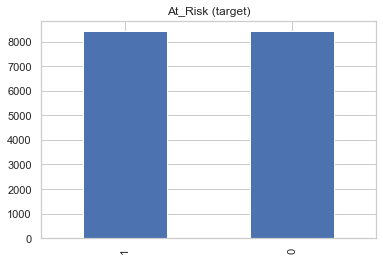

In [234]:
At_Risk_1_over = At_Risk_1.sample(At_Risk_count_0, replace=True)

test_over = pd.concat([At_Risk_1_over, At_Risk_0], axis=0)

print("total At_Risk of 1 and 0:",test_over['At_Risk'].value_counts())# plot the count after under-sampeling
test_over['At_Risk'].value_counts().plot(kind='bar', title='At_Risk (target)')

### Dealing with categorical variables:
In DTs models, we don't need to transfer the categorical variables into dummy variables. However, the algorithm cannot handle string names either. So we should number code the categorical variables. 

In [221]:
df.columns

Index(['Gender', 'Own_car', 'Own_property', 'Work_phone', 'Phone', 'Email',
       'Unemployed', 'Num_children', 'Num_family', 'Account_length',
       'Total_income', 'Age', 'Years_employed', 'Income_type',
       'Education_type', 'Family_status', 'Housing_type', 'Occupation_type',
       'At_Risk'],
      dtype='object')

In [222]:
df.head()

,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,At_Risk
0,1,1,1,1,0,0,0,0,2,15,427500.0,32.868574,12.435574,4.0,1.0,0.0,4.0,12.0,1
1,1,1,1,0,0,0,0,0,2,29,112500.0,58.793815,3.104787,4.0,4.0,1.0,1.0,17.0,0
2,0,0,1,0,1,1,0,0,1,4,270000.0,52.321403,8.353354,0.0,4.0,3.0,1.0,15.0,0
3,0,0,1,0,0,0,1,0,1,20,283500.0,61.504343,0.000000,1.0,1.0,2.0,1.0,12.0,0
4,1,1,1,1,1,1,0,0,2,5,270000.0,46.193967,2.105450,4.0,1.0,1.0,1.0,0.0,0


## Data visualization 

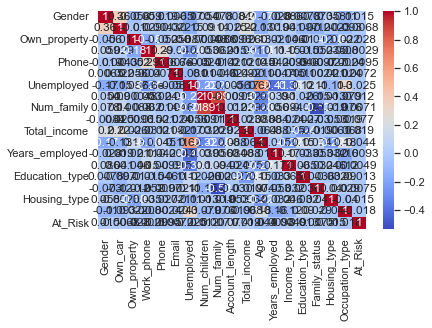

In [223]:
sns.heatmap(df.corr(), cmap='coolwarm',annot=True)
plt.show()

### Defining the variables and splitting the data

In [224]:
y = df['At_Risk']
X = df.drop('At_Risk', axis=1) # becareful inplace= False

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

In [225]:
X_train.head()

,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type
5170,0,1,0,1,1,0,0,0,2,34,31500.0,48.630704,21.174973,0.0,4.0,1.0,1.0,1.0
8346,0,0,1,0,1,0,1,0,2,13,157500.0,57.416648,0.000000,1.0,4.0,1.0,1.0,12.0
3846,0,0,1,0,0,0,0,0,2,14,135000.0,53.682143,11.740145,4.0,4.0,1.0,1.0,9.0
4876,1,1,1,0,0,0,0,1,3,24,225000.0,39.105526,4.405292,4.0,4.0,1.0,1.0,10.0
7405,0,0,0,1,1,0,0,0,2,17,450000.0,55.697242,5.032273,4.0,1.0,1.0,5.0,12.0


### Scaling the features: 


For tree based models, there is no need to scale the features! (No distance metrics is used)

###  DTs Classification with Sklearn

In [227]:
from sklearn.tree import DecisionTreeClassifier

### Decision Tree Parameters

The following table lists key parameters available for this purpose in the sklearn decision tree implementation. After introducing the most important parameters, we will illustrate how to use cross-validation to optimize the hyperparameter settings with respect to the bias-variance tradeoff and lower prediction errors:

| Parameter                | Default | Options                                                                                                                                                               | Description                                                                                                                                                                                                             |
|--------------------------|---------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| criterion                | gini    | Regression: MSE, MAE Classification: Gini impurity, Cross Entropy                                                                                                     | Metric to evaluate split quality.                                                                                                                                                                                       |
| splitter                 | best    | best, random                                                                                                                                                          | How to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.                                                                            |
| max_depth                | None    | int                                                                                                                                                                   | Max # of levels in tree. Split nodes until max_depth is reached or all leaves are pure or all leaves contain less than min_samples_split samples.                                                                       |
| max_features             | None    | None: max_features=n_features; int; float (fraction): int(max_features * n_features)  auto, sqrt: max_features=sqrt(n_features). log2: max_features=log2(n_features). | # of features to consider when evaluating split                                                                                                                                                                         |
| max_leaf_nodes           | None    | None: unlimited # of leaf nodes int                                                                                                                                   | Continue to split nodes that reduce relative impurity the most until reaching max_leaf_nodes.                                                                                                                           |
| min_impurity_decrease    | 0       | float                                                                                                                                                                 | Split node if impurity decreases by at least this value.                                                                                                                                                                |
| min_samples_leaf         | 1       | int; float (as percentage of N)                                                                                                                                       | Minimum # of samples to be at a leaf node. A split will only be considered if there are at least min_samples_leaf training samples in each of the left and right branches. May smoothen the model, esp. for regression. |
| min_samples_split        | 2       | int; float (as percentage of N)                                                                                                                                       | The minimum number of samples required to split an internal node:                                                                                                                                                       |
| min_weight_fraction_leaf | 0       | NA                                                                                                                                                                    | The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided (in fit method).                       |
| class_weight             | None    | balanced: inversely proportional to class frequencies dict: {class_label: weight} list of dicts (for multi-output)                                                    | Weights associated with classes                                                                                                                                                                                         |

In [228]:
Tree_classifier = DecisionTreeClassifier()
Tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [229]:
# Predicting the Test set classes
y_hat       = Tree_classifier.predict(X_test)

----

## Performance metrics:

In [230]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

#### Confusion matrix

In [231]:
print(confusion_matrix(y_test, y_hat))

[[1430  235]
 [ 235   42]]


#### Built-in classification report

In [232]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1665
           1       0.15      0.15      0.15       277

    accuracy                           0.76      1942
   macro avg       0.51      0.51      0.51      1942
weighted avg       0.76      0.76      0.76      1942



---

## Pruning the tree using cost complexity pruning method. 
### Choosing $\alpha$ with cross validation. 

In [126]:
path = DecisionTreeClassifier().cost_complexity_pruning_path(X_train,y_train)

In [127]:
path

{'ccp_alphas': array([0.00000000e+00, 6.36085514e-05, 8.04686494e-05, 8.07842127e-05,
        8.26542177e-05, 8.37397327e-05, 8.42437219e-05, 8.45892662e-05,
        8.48466372e-05, 8.50079066e-05, 8.55362253e-05, 9.65623793e-05,
        9.65623793e-05, 9.99865771e-05, 1.01283207e-04, 1.01338583e-04,
        1.01569317e-04, 1.02999871e-04, 1.02999871e-04, 1.02999871e-04,
        1.02999871e-04, 1.07291533e-04, 1.10357005e-04, 1.10357005e-04,
        1.10357005e-04, 1.10357005e-04, 1.10357005e-04, 1.10357005e-04,
        1.12656109e-04, 1.12656109e-04, 1.12656109e-04, 1.12656109e-04,
        1.12656109e-04, 1.12656109e-04, 1.12656109e-04, 1.12656109e-04,
        1.12656109e-04, 1.14444301e-04, 1.14444301e-04, 1.15874855e-04,
        1.15874855e-04, 1.15874855e-04, 1.15874855e-04, 1.15874855e-04,
        1.15874855e-04, 1.16487950e-04, 1.16487950e-04, 1.16905469e-04,
        1.17045308e-04, 1.17045308e-04, 1.17045308e-04, 1.17045308e-04,
        1.18020686e-04, 1.18020686e-04, 1.18846005

In [128]:
ccp_alphas = path.ccp_alphas

In [129]:
from sklearn.model_selection import cross_val_score
import sklearn.metrics
#sorted(sklearn.metrics.SCORERS.keys())

In [130]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [131]:
f1_cv =[]
for alpha in ccp_alphas:
    f1_score = cross_val_score(estimator = DecisionTreeClassifier(ccp_alpha=alpha), X = X_train, y = y_train, cv = 5 , scoring="f1" )
    f1_cv.append(np.mean(f1_score))
    
output = pd.DataFrame(list(ccp_alphas), columns=['alpha'])
output['f1_CV']=f1_cv

output.head()

,alpha,f1_CV
0,0.000000,0.161020
1,0.000064,0.157152
2,0.000080,0.161051
3,0.000081,0.164744
4,0.000083,0.170352


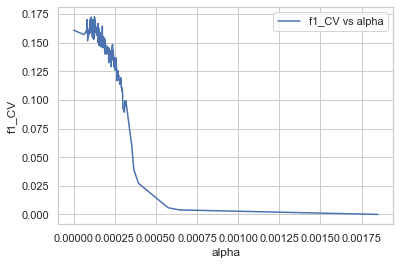

In [132]:
sns.lineplot(x='alpha', y='f1_CV', data=output , color='b', label="f1_CV vs alpha")
plt.show()

In [133]:
np.argmax(output['f1_CV'])

119

In [134]:
output.iloc[np.argmax(output['f1_CV']),]

alpha    0.000127
f1_CV    0.172736
Name: 119, dtype: float64

So the maximum accuracy is 89%.

In [135]:
optimal_alpha = output.iloc[np.argmax(output['f1_CV']),0]
optimal_alpha

0.000127160334876742

Refit the DTs classifier with optimal alpha!

In [136]:
optimal_DT = DecisionTreeClassifier(ccp_alpha=optimal_alpha)
optimal_DT.fit(X_train, y_train)
y_hat_opt = optimal_DT.predict(X_test)

#### Confusion matrix

In [137]:
print(confusion_matrix(y_test, y_hat_opt))

[[1457  208]
 [ 239   38]]


#### Built-in classification report

In [138]:
print(classification_report(y_test, y_hat_opt))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1665
           1       0.15      0.14      0.15       277

    accuracy                           0.77      1942
   macro avg       0.51      0.51      0.51      1942
weighted avg       0.76      0.77      0.76      1942



###  Cross validation

Now let's try to get an estimate for the accuracy of our model using cross validation technique. 

In [139]:
from sklearn.model_selection import cross_val_score

In [140]:
# remember we saved our model in an object called "Tree_classifier"
accuracy = cross_val_score(estimator = optimal_DT, X = X_train, y = y_train, cv = 5 , scoring="f1" )

In [141]:
f1_score

array([0., 0., 0., 0., 0.])

In [142]:
round(f1_score.mean(),3)

0.0

## Visualizing the Tree
4 different ways of visualizing a tree in Python: https://mljar.com/blog/visualize-decision-tree/

Plot DT with **plot_tree** method from sklearn. 

Let's visualize one simple tree with two features only. 


In [143]:
df.columns

Index(['ID', 'Gender', 'Own_car', 'Own_property', 'Work_phone', 'Unemployed',
       'Account_length', 'Total_income', 'Age', 'Years_employed',
       'Income_type', 'Education_type', 'Family_status', 'Housing_type',
       'Occupation_type', 'At_Risk'],
      dtype='object')

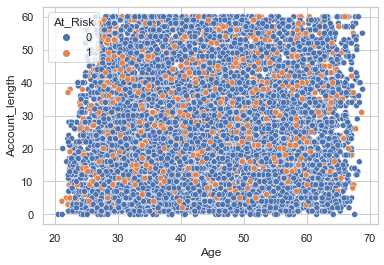

In [144]:
sns.scatterplot(x='Age', y='Account_length', data=df, hue='At_Risk')
plt.show()

In [145]:
dtree= DecisionTreeClassifier(max_depth=4, min_samples_leaf=50)
dtree.fit(X_train, y_train)
yhat = dtree.predict(X_test)

In [146]:
from sklearn.tree import plot_tree

In [147]:
X_train.shape

(7767, 15)

In [148]:
X_train.head()

,ID,Gender,Own_car,Own_property,Work_phone,Unemployed,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type
5170,5088968,0,1,0,1,0,34,31500.0,48.630704,21.174973,0.0,4.0,1.0,1.0,1.0
8346,5126091,0,0,1,0,1,13,157500.0,57.416648,0.000000,1.0,4.0,1.0,1.0,12.0
3846,5058270,0,0,1,0,0,14,135000.0,53.682143,11.740145,4.0,4.0,1.0,1.0,9.0
4876,5079008,0,1,1,0,0,24,225000.0,39.105526,4.405292,4.0,4.0,1.0,1.0,10.0
7405,5113915,0,0,0,1,0,17,450000.0,55.697242,5.032273,4.0,1.0,1.0,5.0,12.0


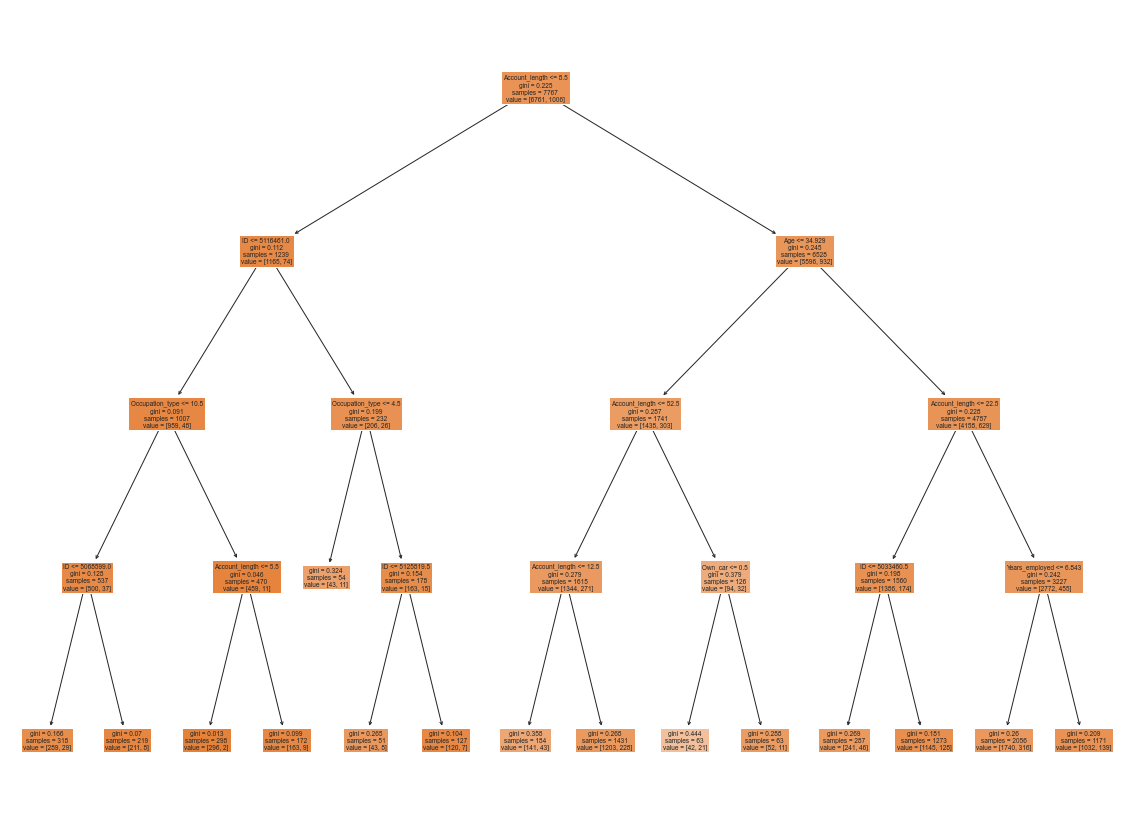

In [149]:
fig = plt.figure(figsize=(20,15))
DT_plot = plot_tree(dtree, feature_names=X_train.columns, filled=True)
# left branch True

In [150]:
fig.savefig("DT_plot_classification.png")

**Exercise**: 
Now try the optimal alpha and answer the following questions:
1. What is the level?
2. What is |T|?
3. How do you make sure that each terminal node has at least 50 boservations?

---
### Advance Visualization (this part is optional) 

Visualising the Training set results (in 2D of course!). We have to rerun the whole model with 2 explanatory variables

In [151]:
X= df[['Age', 'Account_length']]
y= df[['At_Risk']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [152]:
# Feature Scaling: only for visualization purposes we need to scale the features. 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) 

### Fitting Decision Tree classifier to the Training set

In [153]:
dtree = DecisionTreeClassifier(max_depth=2)
dtree.fit(X_train, y_train.values.reshape(-1,))
y_hat_vis = dtree.predict(X_test)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


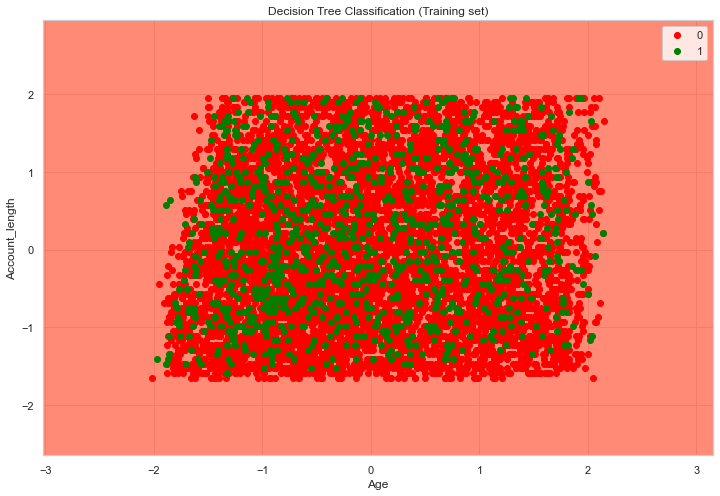

In [154]:
# visualization
plt.figure(figsize=(12,8))

X_set, y_set = X_train, y_train.iloc[:,0].values
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))


from matplotlib.colors import ListedColormap
plt.contourf( X1, X2 , dtree.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('#FF6347', '#90EE90')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Decision Tree Classification (Training set)')
plt.xlabel('Age')
plt.ylabel('Account_length')
plt.legend()
plt.show()

**Exercise**
1. If you use max_depth=100, what is the accuracy in the training set? 



### Visualising the Test set results

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


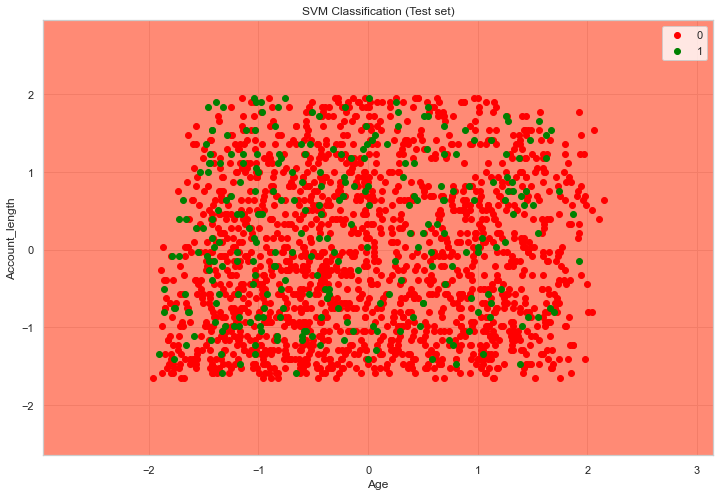

In [155]:
plt.figure(figsize=(12,8))

from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test.iloc[:,0].values
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, dtree.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('#FF6347', '#90EE90')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM Classification (Test set)')
plt.xlabel('Age')
plt.ylabel('Account_length')
plt.legend()
plt.show()

In [156]:
print(confusion_matrix(y_test, y_hat_vis))

[[1673    0]
 [ 269    0]]


# Random Forest Classification

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  #if you want to use seaborn themes with matplotlib functions
import warnings
warnings.filterwarnings('ignore')

In [3]:
rand_state= 1000

In [4]:
df = pd.read_csv('finalproject_cleandata.csv')

In [5]:
df.head()

,ID,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,At_Risk
0,5008804,1,1,1,1,0,0,0,0,2,15,427500.0,32.868574,12.435574,Working,Higher education,Civil marriage,Rented apartment,Other,1
1,5008806,1,1,1,0,0,0,0,0,2,29,112500.0,58.793815,3.104787,Working,Secondary / secondary special,Married,House / apartment,Security staff,0
2,5008808,0,0,1,0,1,1,0,0,1,4,270000.0,52.321403,8.353354,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,0
3,5008812,0,0,1,0,0,0,1,0,1,20,283500.0,61.504343,0.000000,Pensioner,Higher education,Separated,House / apartment,Other,0
4,5008815,1,1,1,1,1,1,0,0,2,5,270000.0,46.193967,2.105450,Working,Higher education,Married,House / apartment,Accountants,0


### Exploring the variables:

1. __ID__ : ID of each client 

2. __LIMIT_BAL__: Amount of given credit in NT dollars (includes individual and family/supplementary credit) 


3. __SEX__: Gender (1=male, 2=female)

4. __EDUCATION__: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

5. __MARRIAGE__: Marital status (1=married, 2=single, 3=others)

6. __AGE__: Age in years

7. __PAY_1__: Repayment status in September, 2005 (-2 = No consumption, -1 = paid in full, 0 = use of revolving credit (paid minimum only), 1 = payment delay for one month, 2 = payment delay for two months, ... 8 = payment delay for eight months, 9 = payment delay for nine months and above)

8. __PAY_2__: Repayment status in August, 2005 (scale same as above)

9. __PAY_3__: Repayment status in July, 2005 (scale same as above)

10. __PAY_4__: Repayment status in June, 2005 (scale same as above)

11. __PAY_5__: Repayment status in May, 2005 (scale same as above)

12. __PAY_6__: Repayment status in April, 2005 (scale same as above)

13. __BILL_AMT1__: Amount of bill statement in September, 2005 (NT dollar)

14. __BILL_AMT2__: Amount of bill statement in August, 2005 (NT dollar)

15. __BILL_AMT3__: Amount of bill statement in July, 2005 (NT dollar)

16. __BILL_AMT4__: Amount of bill statement in June, 2005 (NT dollar)

17. __BILL_AMT5__: Amount of bill statement in May, 2005 (NT dollar)

18. __BILL_AMT6__: Amount of bill statement in April, 2005 (NT dollar)

19. __PAY_AMT1__: Amount of previous payment in September, 2005 (NT dollar)

20. __PAY_AMT2__: Amount of previous payment in August, 2005 (NT dollar)

21. __PAY_AMT3__: Amount of previous payment in July, 2005 (NT dollar)

22. __PAY_AMT4__: Amount of previous payment in June, 2005 (NT dollar)

23. __PAY_AMT5__: Amount of previous payment in May, 2005 (NT dollar)

24. __PAY_AMT6__: Amount of previous payment in April, 2005 (NT dollar)

25. __default.payment.next.month__: Default payment (1=yes, 0=no)


*Note: NT is Taiwain Dollars*





In [6]:
df.isnull().sum()/len(df)

ID                 0.0
Gender             0.0
Own_car            0.0
Own_property       0.0
Work_phone         0.0
Phone              0.0
Email              0.0
Unemployed         0.0
Num_children       0.0
Num_family         0.0
Account_length     0.0
Total_income       0.0
Age                0.0
Years_employed     0.0
Income_type        0.0
Education_type     0.0
Family_status      0.0
Housing_type       0.0
Occupation_type    0.0
At_Risk            0.0
dtype: float64

Looks good!
Now let's see if there are any duplicates!

In [7]:
sum(df.duplicated())

0

In [8]:
# dropping the duplicates:
df.drop_duplicates(inplace=True)

In [9]:
df.nunique()

ID                 9709
Gender                2
Own_car               2
Own_property          2
Work_phone            2
Phone                 2
Email                 2
Unemployed            2
Num_children          9
Num_family           10
Account_length       61
Total_income        263
Age                7172
Years_employed     3637
Income_type           5
Education_type        5
Family_status         5
Housing_type          6
Occupation_type      19
At_Risk               2
dtype: int64

---

## Encode ordinal categorical features as an integer array.

In random forest we don't need to transfer the categorical variables into dummy variables (using one-hot-encoding). However, the algorithm is not able to handel ordinal data. We should transform ordinal categorical variables into quantitative variables. 

It seems that **SEX, EDUCATION, MARRIAGE** are ordinal categotical variables and should be transformed into numerics


In [10]:
ordinal_categoricals = ['Income_type', 'Education_type', 'Family_status', 'Housing_type', 'Occupation_type']

In [11]:
from sklearn.preprocessing import OrdinalEncoder

In [12]:
enc = OrdinalEncoder()

In [13]:
df[ordinal_categoricals]= enc.fit_transform(df[ordinal_categoricals])

In [14]:
df.head()

,ID,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,At_Risk
0,5008804,1,1,1,1,0,0,0,0,2,15,427500.0,32.868574,12.435574,4.0,1.0,0.0,4.0,12.0,1
1,5008806,1,1,1,0,0,0,0,0,2,29,112500.0,58.793815,3.104787,4.0,4.0,1.0,1.0,17.0,0
2,5008808,0,0,1,0,1,1,0,0,1,4,270000.0,52.321403,8.353354,0.0,4.0,3.0,1.0,15.0,0
3,5008812,0,0,1,0,0,0,1,0,1,20,283500.0,61.504343,0.000000,1.0,1.0,2.0,1.0,12.0,0
4,5008815,1,1,1,1,1,1,0,0,2,5,270000.0,46.193967,2.105450,4.0,1.0,1.0,1.0,0.0,0


In [15]:
enc.categories_

[array(['Commercial associate', 'Pensioner', 'State servant', 'Student',
        'Working'], dtype=object),
 array(['Academic degree', 'Higher education', 'Incomplete higher',
        'Lower secondary', 'Secondary / secondary special'], dtype=object),
 array(['Civil marriage', 'Married', 'Separated', 'Single / not married',
        'Widow'], dtype=object),
 array(['Co-op apartment', 'House / apartment', 'Municipal apartment',
        'Office apartment', 'Rented apartment', 'With parents'],
       dtype=object),
 array(['Accountants', 'Cleaning staff', 'Cooking staff', 'Core staff',
        'Drivers', 'HR staff', 'High skill tech staff', 'IT staff',
        'Laborers', 'Low-skill Laborers', 'Managers', 'Medicine staff',
        'Other', 'Private service staff', 'Realty agents', 'Sales staff',
        'Secretaries', 'Security staff', 'Waiters/barmen staff'],
       dtype=object)]

Remember, with other machine learning models, we ended up with **78 features** using the same data set because we had to transform categorical variables into dummies. But with RF, there is only **23 features** to work with. 

### Scaling features
In random forest, we don't need to scale the features!! 

In [16]:
# first we look at target variable proportions:
pd.crosstab(df['At_Risk'],df['At_Risk'], normalize='all')*100

At_Risk,0,1
At_Risk,,
0,86.785457,0.000000
1,0.000000,13.214543


### Defining the variables and splitting the data

In [17]:
df.columns

Index(['ID', 'Gender', 'Own_car', 'Own_property', 'Work_phone', 'Phone',
       'Email', 'Unemployed', 'Num_children', 'Num_family', 'Account_length',
       'Total_income', 'Age', 'Years_employed', 'Income_type',
       'Education_type', 'Family_status', 'Housing_type', 'Occupation_type',
       'At_Risk'],
      dtype='object')

In [18]:
y = df['At_Risk']
X = df.drop(['At_Risk','ID'], axis=1) # becareful inplace= False

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_state)

---

## Random Forest Classification with Sklearn

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
# Fitting RF classifier to the Training set

RF_classifier = RandomForestClassifier()
RF_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [21]:
# Predicting the Test set probabilities and classes
y_hat      = RF_classifier.predict(X_test)
y_hat_probs = RF_classifier.predict_proba(X_test)[:,1] 
# predicted probabilities are reported for both classes. we saved the prob of purchased!

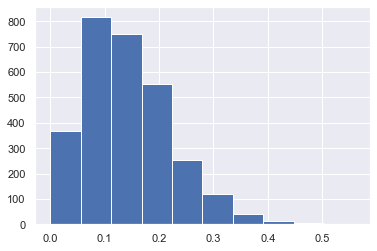

In [22]:
plt.hist(y_hat_probs)
plt.show()

---
## Evaluating the model performance on test data

In [23]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

#### Confusion matrix

In [24]:
print(confusion_matrix(y_test, y_hat))

[[2510    2]
 [ 401    0]]


#### Built-in classification report

In [25]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93      2512
           1       0.00      0.00      0.00       401

    accuracy                           0.86      2913
   macro avg       0.43      0.50      0.46      2913
weighted avg       0.74      0.86      0.80      2913



---------------

## Tuning hyperparameters: 

The key configuration parameters include the various hyperparameters for the individual decision trees introduced in the decision tree notebook. 

The following tables lists additional options for the two `RandomForest` classes:


| Keyword      | Default | Description                                                                                                                |
|--------------|---------|----------------------------------------------------------------------------------------------------------------------------|
| bootstrap    | True    | Bootstrap samples during training                                                                                          |
| n_estimators | 10      | # trees in the forest.                                                                                                     |
| oob_score    | False   | Use out-of-bag samples to estimate the R2 on unseen data                                                                   |
| max_features | auto    | The number of features to consider when looking for the best split                                                         |


- The `bootstrap` parameter activates in the preceding bagging algorithm outline, which in turn enables the computation of the out-of-bag score (oob_score) that estimates the generalization accuracy using samples not included in the bootstrap sample used to train a given tree (see next section for detail). 
- The `n_estimators` parameter defines the number of trees to be grown as part of the forest. Larger forests perform better, but also take more time to build. It is important to monitor the cross-validation error as a function of the number of base learners to identify when the marginal reduction of the prediction error declines and the cost of additional training begins to outweigh the benefits.
- The `max_features` parameter controls the size of the randomly selected feature subsets available when learning a new decision rule and split a node. A lower value reduces the correlation of the trees and, thus, the ensemble's variance, but may also increase the bias. Good starting values are `n_features` (the number of training features) for regression problems and `sqrt(n_features)` for classification problems, but will depend on the relationships among features and should be optimized using cross-validation.

Random forests are designed to contain deep fully-grown trees, which can be created using `max_depth=None` and `min_samples_split=2`. However, these values are not necessarily optimal, especially for high-dimensional data with many samples and, consequently, potentially very deep trees that can become very computationally-, and memory-, intensive.

The `RandomForest` class provided by sklearn support parallel training and prediction by setting the n_jobs parameter to the k number of jobs to run on different cores. The -1 value uses all available cores. The overhead of interprocess communication may limit the speedup from being linear so that k jobs may take more than 1/k the time of a single job. Nonetheless, the speedup is often quite significant for large forests or deep individual trees that may take a meaningful amount of time to train when the data is large, and split evaluation becomes costly.

As always, the best parameter configuration should be identified using cross-validation. The following steps illustrate the process:


### Gridsearch

In [26]:
my_param_grid = {'n_estimators':[100,500], 'criterion':['entropy','gini'],
                 'max_features':['log2'], 'max_depth':[10]}

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
grid = GridSearchCV(estimator=RandomForestClassifier(random_state=rand_state),param_grid= my_param_grid, refit = True, verbose=2, cv=5 )
# verbose just means the text output describing the process. (the greater the number the more detail you will get).

In [29]:
# May take a while!
grid.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100; total time=   0.6s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100; total time=   0.6s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100; total time=   0.8s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100; total time=   0.5s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100; total time=   0.5s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=500; total time=   2.6s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=500; total time=   2.8s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=500; total time=   2.8s
[CV] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=500; total time=   2.6s
[CV] END criterion=entropy, max_depth=10, max_features=log

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1000),
             param_grid={'criterion': ['entropy', 'gini'], 'max_depth': [10],
                         'max_features': ['log2'], 'n_estimators': [100, 500]},
             verbose=2)

In [30]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'log2',
 'n_estimators': 100}

In [31]:
grid.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       random_state=1000)

In [32]:
y_hat_optimized = grid.predict(X_test)

#### Confusion matrix

In [33]:
print(confusion_matrix(y_test, y_hat_optimized))

[[2512    0]
 [ 401    0]]


#### Built-in classification report

In [34]:
print(classification_report(y_test, y_hat_optimized))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93      2512
           1       0.00      0.00      0.00       401

    accuracy                           0.86      2913
   macro avg       0.43      0.50      0.46      2913
weighted avg       0.74      0.86      0.80      2913



## Exercise:
1. Use cross validation to estimate the accuracy in the test set.
2. Use OOB observations to estimate the accuracy in the test set.

---

## Dealing with imbalanced target variables!

In [37]:
pd.crosstab(df['At_Risk'],df['At_Risk'], normalize='all')*100

At_Risk,0,1
At_Risk,,
0,86.785457,0.000000
1,0.000000,13.214543


The difference in weights will influence the classification of the classes during the training phase. The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class. Here is an example: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

In [38]:
RF_balanced = RandomForestClassifier(random_state=1000, criterion='entropy', max_features='log2', max_depth=10, class_weight='balanced_subsample')

In [39]:
y_hat_balanced = RF_balanced.fit(X_train, y_train).predict(X_test)

#### Confusion matrix

In [40]:
print(confusion_matrix(y_test, y_hat_balanced))

[[2129  383]
 [ 335   66]]


#### Built-in classification report

In [41]:
print(classification_report(y_test, y_hat_balanced))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      2512
           1       0.15      0.16      0.16       401

    accuracy                           0.75      2913
   macro avg       0.51      0.51      0.51      2913
weighted avg       0.77      0.75      0.76      2913



### ROC and AUC 

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score

No Skill     : ROC AUC=0.500
Random Forest: ROC AUC=0.554


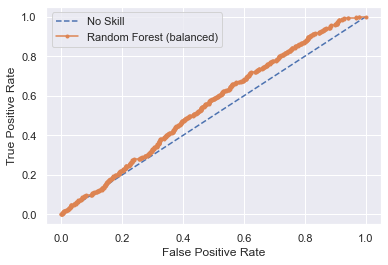

In [43]:
# generate a no skill (ns) prediction and logistic regression (lr) predictions.
ns_probs = [0 for i in range(len(y_test))]
lr_probs = RF_balanced.predict_proba(X_test)[:,1]
# calculating scores for no skill and logistic regression
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill     : ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest (balanced)')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Based on **AUC=0.789**, the model is doing a better job compared to random prediction.

Recall: the best we could do with Logistic regression was **AUC=0.66**

----------------

## Feature Importance

In [44]:
features = list(X_train.columns)
features

['Gender',
 'Own_car',
 'Own_property',
 'Work_phone',
 'Phone',
 'Email',
 'Unemployed',
 'Num_children',
 'Num_family',
 'Account_length',
 'Total_income',
 'Age',
 'Years_employed',
 'Income_type',
 'Education_type',
 'Family_status',
 'Housing_type',
 'Occupation_type']

In [45]:
importance = RF_balanced.feature_importances_
importance

array([0.01560995, 0.0191527 , 0.02216362, 0.0162258 , 0.02042542,
       0.01480736, 0.00716843, 0.02151985, 0.03658932, 0.19265186,
       0.12326843, 0.17007562, 0.15060749, 0.0309537 , 0.02210226,
       0.03765479, 0.02115769, 0.07786571])

In [46]:
FIM = pd.DataFrame({'Features': features , 'Feature_importance':importance})
FIM = FIM.sort_values(by=['Feature_importance'])
FIM

,Features,Feature_importance
6,Unemployed,0.007168
5,Email,0.014807
0,Gender,0.015610
3,Work_phone,0.016226
1,Own_car,0.019153
4,Phone,0.020425
16,Housing_type,0.021158
7,Num_children,0.021520
14,Education_type,0.022102
2,Own_property,0.022164


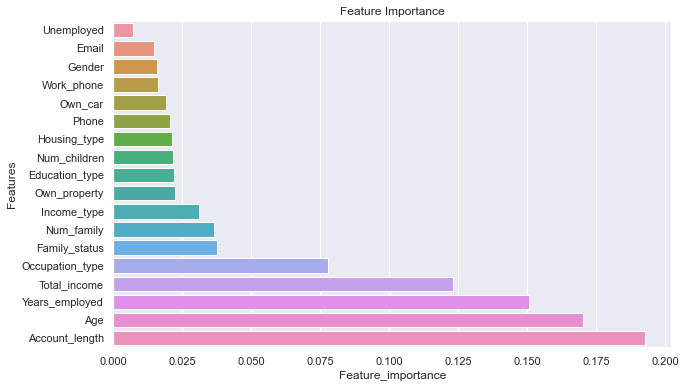

In [47]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(y='Features', x='Feature_importance', data=FIM)
plt.show()

Recall:
- PAY_1: repayment status in the past 1 month (paid in full, paid minimum due, delay for # months)
- PAY_2: repayment status in the past 2 months
- .... 
- BILL_AMT: amount of bill statement
